In [4]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from tensorflow import keras


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

dict = unpickle("C:\\Users\\Samuel\\Downloads\\cifar-10-batches-py\\data_batch_1")

In [5]:
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical   


(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [6]:
print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

plt.imshow(train_x_orig[7])
print(classes[np.squeeze(train_y[:,7])].decode('utf-8'))

m_train = train_y.shape[1]
m_test = test_y.shape[1]
num_px = train_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

array([3], dtype=uint8)

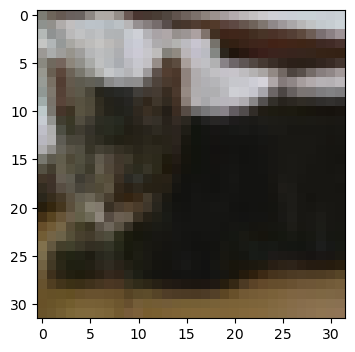

In [28]:
plt.imshow(X_train[9])
y_train[9]

In [178]:
cats=np.zeros((5000,32,32,3),dtype=int)
not_cats=np.zeros((5000,32,32,3),dtype=int)
j=0
k=0
for i in range(50000):
    if y_train[i]==3:
        cats[j]=X_train[i]
        j+=1
    elif k<5000:
        not_cats[k]=X_train[i]
        k+=1
    
cats_test=np.zeros((1000,32,32,3),dtype=int)
not_cats_test=np.zeros((1000,32,32,3),dtype=int)
l=0
m=0
for i in range(10000):
    if y_test[i]==3:
        cats_test[l]=X_test[i]
        l+=1
    elif m<1000:
        not_cats_test[m]=X_test[i]
        m+=1        
        
bin_x_train=np.zeros((10000,32,32,3),dtype=int)
bin_y_train=np.zeros((10000,1),dtype=int)
bin_x_test=np.zeros((2000,32,32,3),dtype=int)
bin_y_test=np.zeros((2000,1),dtype=int)

for i in range(5000):
    bin_x_train[2*i]=cats[i]
    bin_y_train[2*i]=1
    bin_x_train[2*i+1]=not_cats[i]
    bin_y_train[2*i+1]=0
    
for i in range(1000):
    bin_x_test[2*i]=cats_test[i]
    bin_y_test[2*i]=1
    bin_x_test[2*i+1]=not_cats_test[i]
    bin_y_test[2*i+1]=0

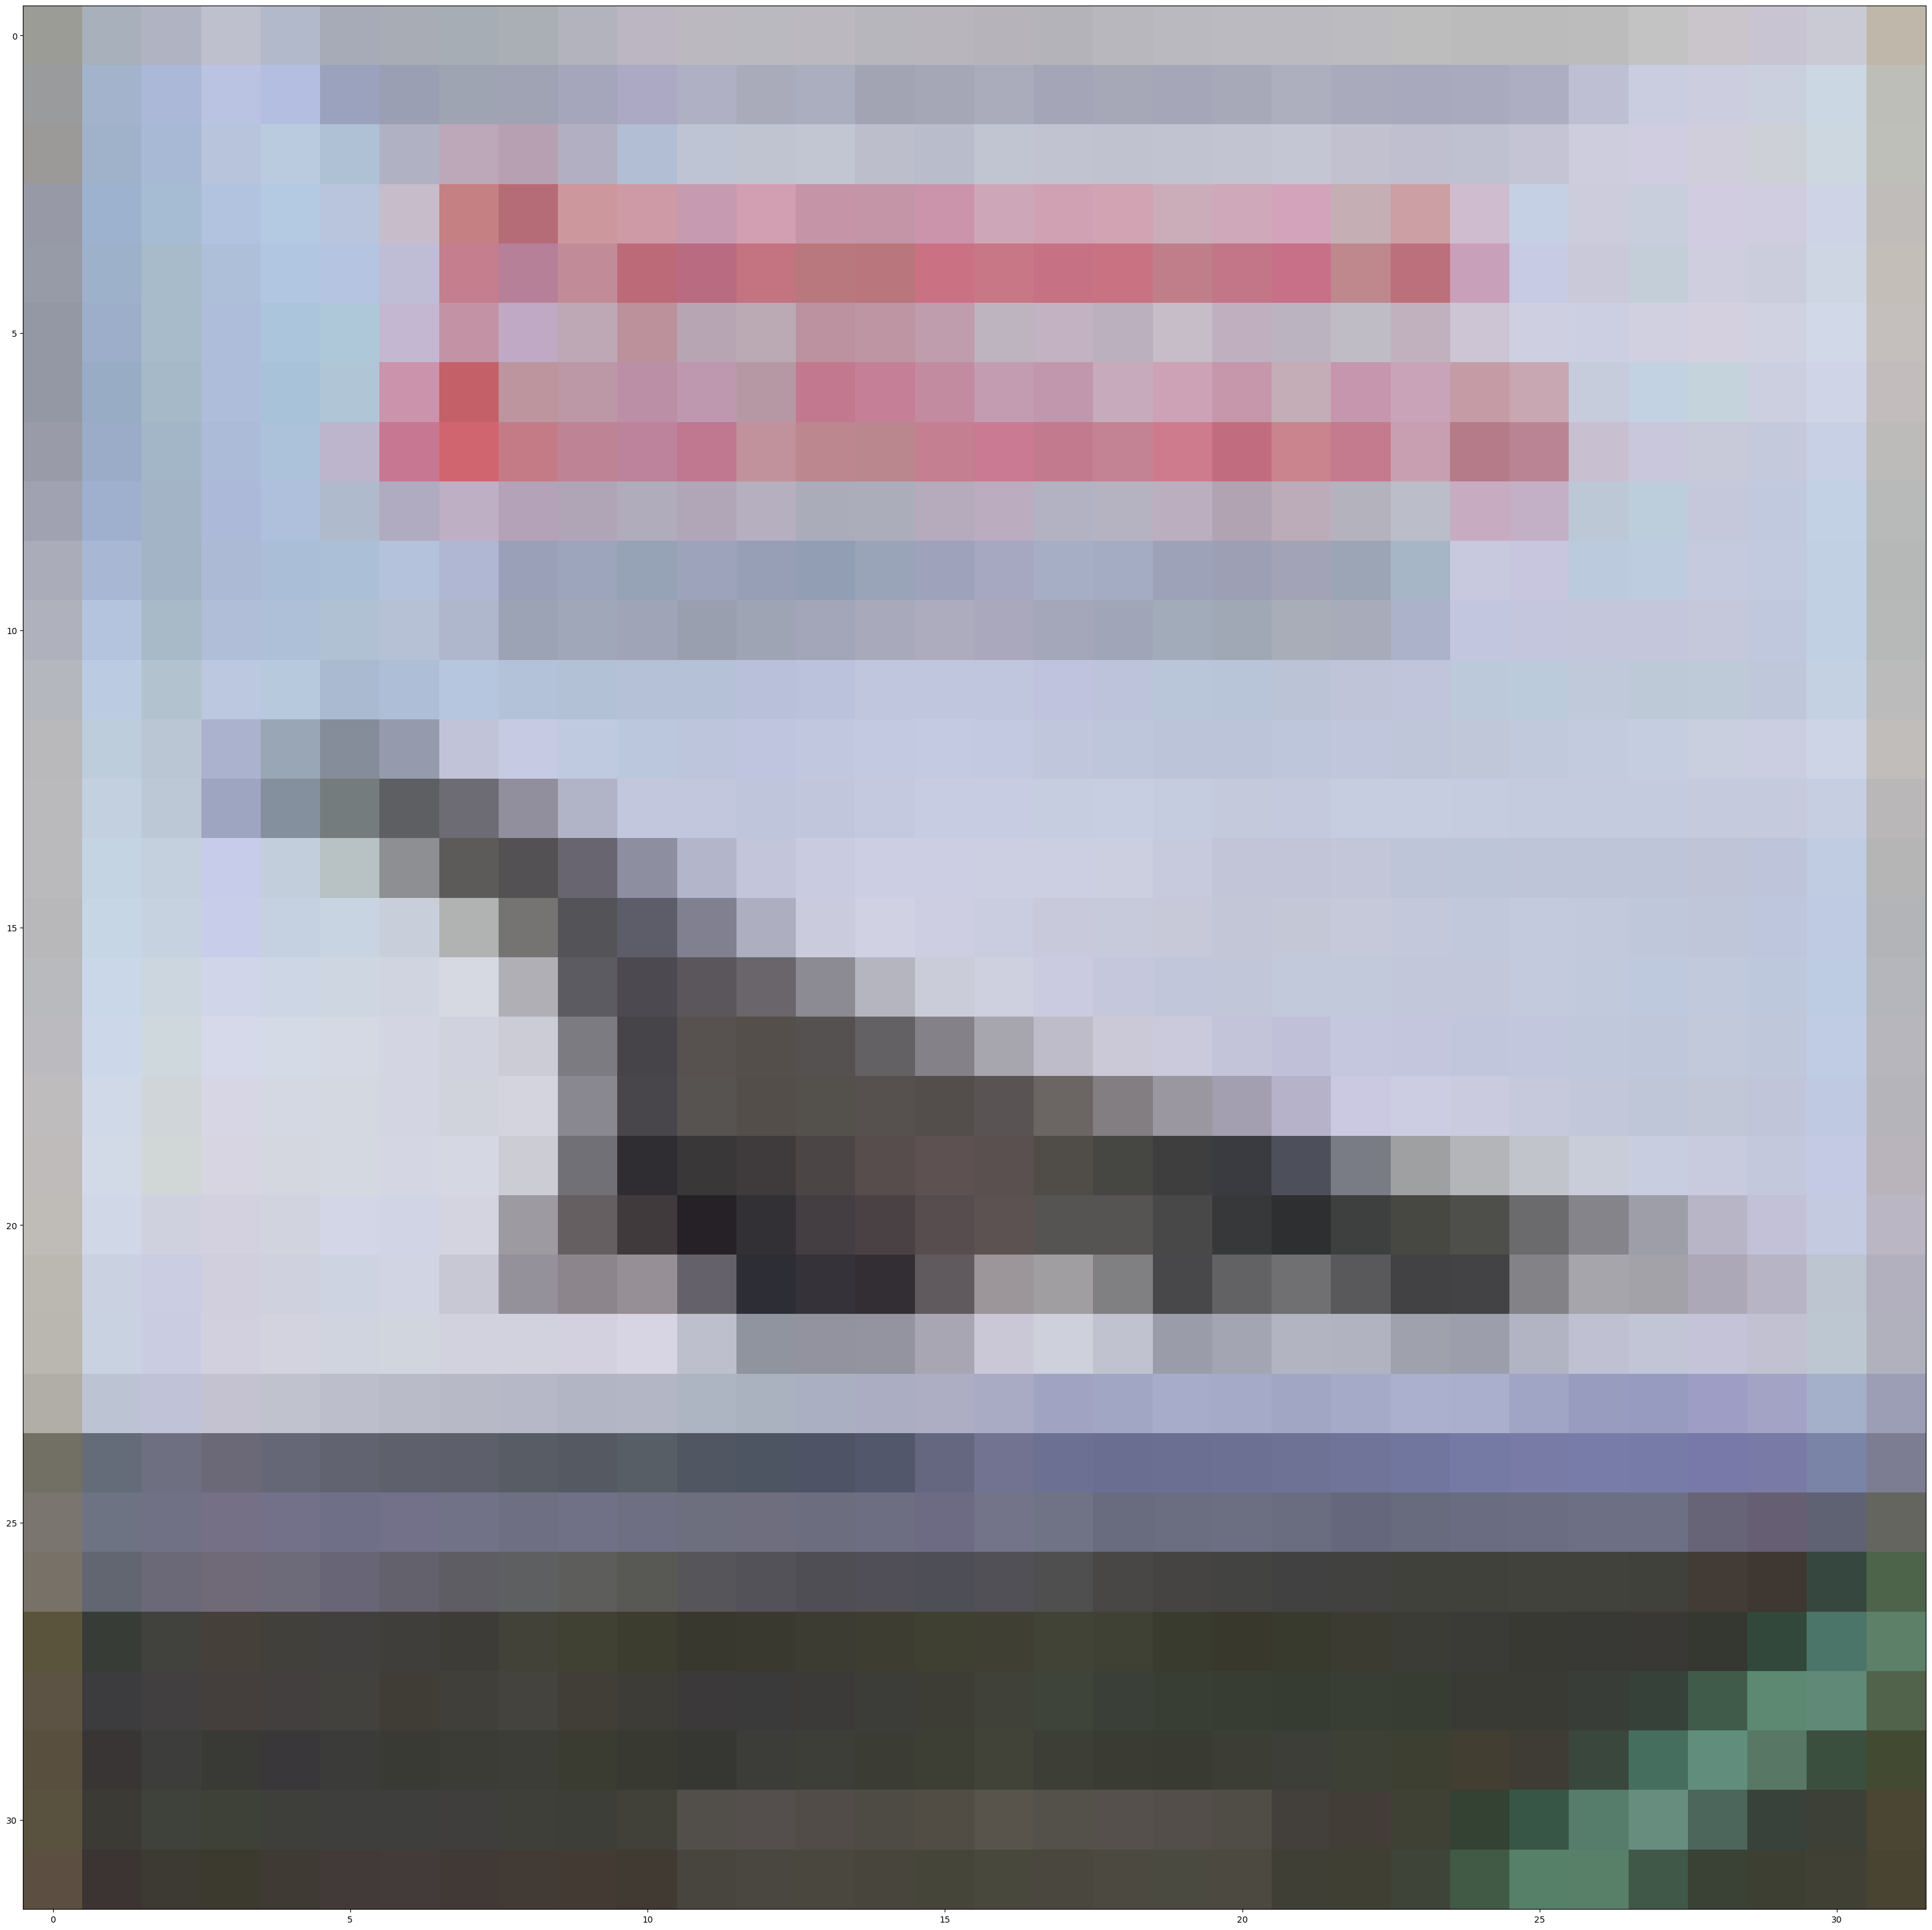

In [185]:
plt.imshow(bin_x_test[5])


In [186]:
train_x_flatten = bin_x_train.reshape(bin_x_train.shape[0], -1).T
test_x_flatten = bin_x_test.reshape(bin_x_test.shape[0], -1).T
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.

print ("train_x_flatten shape: " + str(train_x.shape))

print ("test_x_flatten shape: " + str(test_x.shape))

print ("sanity check after reshaping: " + str(train_x[0:5,0]))

train_x_flatten shape: (3072, 10000)
test_x_flatten shape: (3072, 2000)
sanity check after reshaping: [0.49019608 0.49019608 0.45490196 0.43137255 0.39607843]


train_y=np.zeros((10,50000))
test_y=np.zeros((10,10000))

for i in range(50000):
    train_y[y_train[i],i]=1
for i in range(10000):
    test_y[y_test[i],i]=1
    
print ("train_y shape: " + str(train_y.shape))
print ("test_y shape: " + str(test_y.shape))
print ("sanity check after reshaping: " + str(train_y[0:5]))

In [188]:
train_y=bin_y_train.T
test_y=bin_y_test.T

print ("train_y shape: " + str(train_y.shape))
print ("test_y shape: " + str(test_y.shape))
print ("sanity check after reshaping: " + str(train_y[0:5]))

train_y shape: (1, 10000)
test_y shape: (1, 2000)
sanity check after reshaping: [[1 0 1 ... 0 1 0]]


In [74]:
def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def arctan(Z):
    A = np.arctan(Z)
    cache = Z
    return A, cache

def arctan_backward(dA, cache):
    Z = cache
    dZ = dA / (Z*Z+1)
    
    return dZ
    
def softplus(Z):
    A = np.log(1+np.exp(Z))
    cache = Z
    return A, cache

def softplus_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s
    
    return dZ

In [116]:
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    Z, linear_cache = linear_forward(A_prev, W, b)
    
    if activation == "sigmoid":        
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "arctan":
        A, activation_cache = arctan(Z)
    elif activation == "softplus":
        A, activation_cache = softplus(Z)    
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def forward(X, parameters, activation):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    activation -- activation function
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation)
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
    
            
    return AL, caches



def compute_cost(AL, Y,fcn):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    
    m = Y.shape[1]
    n = Y.shape[0]
    epsilon = 1e-6
    
    if fcn=="logistic":
        cost = (1./(m)) * np.sum((Y*np.log(AL+epsilon)) - ((1-Y)*np.log(1-AL+epsilon)))
    
        cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
        assert(cost.shape == ())
    
        return cost
    elif fcn == "l2":
        
        # Compute loss from aL and y.
        cost = (1./(2*m)) * (np.dot(AL-Y,(AL-Y).T))

        cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
        assert(cost.shape == ())

        return cost
    elif fcn == "CE":
        log_likelihood = -Y.T*np.log(AL.T+epsilon)
        cost = np.sum(log_likelihood) / m

        cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
        assert(cost.shape == ())

        return cost
        

def d_cost(AL,Y,fcn):
    epsilon = 1e-6
    if fcn=="l2":
        return AL-Y
    elif fcn == "logistic":
        return - (np.divide(Y, AL+epsilon) - np.divide(1 - Y, (1 - AL)+epsilon))
    elif fcn == "CE":
        return - (np.divide(Y,AL+epsilon))
    
    

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    elif activation == "arctan":   
        dZ = arctan_backward(dA, activation_cache)
    elif activation == "softplus":   
        dZ = softplus_backward(dA, activation_cache)    
        
        
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db


def backward(AL, Y,activation, caches, loss):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    
    dAL = d_cost(AL,Y,loss)
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = activation_backward(dAL, current_cache, "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = activation_backward(grads["dA" + str(l + 2)], current_cache, activation)
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [110]:
def predict(X, y, parameters, activation = "sigmoid"):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = forward(X, parameters,activation)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    return np.sum((p == y)/m)
        

    

In [111]:
def Neural_Network(X_in, Y_in, layers_dims, activation = "sigmoid", learning_rate = 0.0075, num_iterations = 3000, print_cost=False, print_acc=False, loss="l2"):#lr was 0.009

    validation_cut=round((X_in.shape[1])*.9)
    X=X_in[:,0:validation_cut]
    Y=Y_in[:,0:validation_cut]
    X_valid=X_in[:,validation_cut:X_in.shape[1]]
    Y_valid=Y_in[:,validation_cut:Y_in.shape[1]]
    np.random.seed(1)
    costs = []    # keep track of cost
    accs  = []
    max_acc=0
    
    parameters = initialize_parameters(layers_dims)
     
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = forward(X, parameters, activation)
        
        # Backward propagation
        grads = backward(AL, Y,activation, caches, loss)
 
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            cost = compute_cost(AL, Y,loss)
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
            
       
        # Print the accuracy every 100 training example
        if print_acc and i % 100 == 0:
            acc = predict(X_valid,Y_valid,parameters,activation)
            if acc>max_acc:
                max_acc=acc
                max_acc_params=parameters
                temp_i=i
                print(max_acc)
                print(temp_i)
            print ("Accuracy after iteration %i: %f" %(i, acc))
            if acc <= max_acc and i>=temp_i+1000:
                print("break")
                break
            accs.append(acc)
            
            
    # plot the cost
    if print_cost:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
    # plot the Accuracy
    if print_acc:
        plt.plot(np.squeeze(accs))
        plt.ylabel('Accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        return max_acc_params
    
    return parameters

0.5000000000000002
0
Accuracy after iteration 0: 0.500000
0.5850000000000001
100
Accuracy after iteration 100: 0.585000
0.5960000000000001
200
Accuracy after iteration 200: 0.596000
0.5970000000000001
300
Accuracy after iteration 300: 0.597000
0.5980000000000001
400
Accuracy after iteration 400: 0.598000
0.6020000000000001
500
Accuracy after iteration 500: 0.602000
0.6140000000000001
600
Accuracy after iteration 600: 0.614000
Accuracy after iteration 700: 0.611000
0.6190000000000001
800
Accuracy after iteration 800: 0.619000
0.6240000000000001
900
Accuracy after iteration 900: 0.624000
Accuracy after iteration 1000: 0.624000
Accuracy after iteration 1100: 0.618000
Accuracy after iteration 1200: 0.619000
Accuracy after iteration 1300: 0.619000
Accuracy after iteration 1400: 0.622000
Accuracy after iteration 1500: 0.623000
0.6270000000000001
1600
Accuracy after iteration 1600: 0.627000
0.6330000000000001
1700
Accuracy after iteration 1700: 0.633000
0.6370000000000001
1800
Accuracy after 

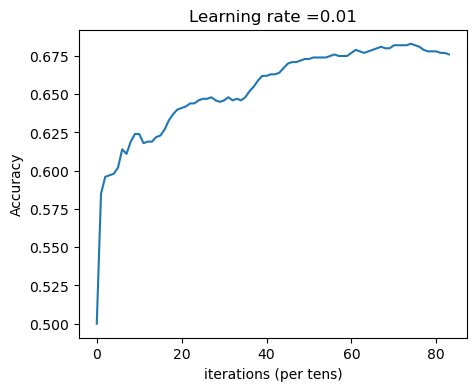

In [99]:
layers_dims = [3072, 100, 1]
parameters1 = Neural_Network(train_x, train_y, layers_dims, activation = "sigmoid",learning_rate = 0.01, num_iterations = 50000, print_acc = True, loss="logistic")

0.5000000000000002
0
Accuracy after iteration 0: 0.500000
Accuracy after iteration 100: 0.426000
Accuracy after iteration 200: 0.453000
Accuracy after iteration 300: 0.492000
0.522
400
Accuracy after iteration 400: 0.522000
0.549
500
Accuracy after iteration 500: 0.549000
0.56
600
Accuracy after iteration 600: 0.560000
0.5640000000000001
700
Accuracy after iteration 700: 0.564000
0.5740000000000001
800
Accuracy after iteration 800: 0.574000
0.5790000000000001
900
Accuracy after iteration 900: 0.579000
0.5810000000000001
1000
Accuracy after iteration 1000: 0.581000
0.5890000000000001
1100
Accuracy after iteration 1100: 0.589000
0.5920000000000001
1200
Accuracy after iteration 1200: 0.592000
Accuracy after iteration 1300: 0.591000
Accuracy after iteration 1400: 0.590000
Accuracy after iteration 1500: 0.592000
Accuracy after iteration 1600: 0.591000
Accuracy after iteration 1700: 0.588000
Accuracy after iteration 1800: 0.588000
Accuracy after iteration 1900: 0.589000
Accuracy after iterat

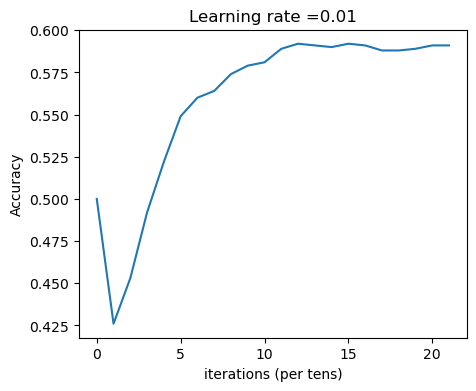

In [108]:
layers_dims = [3072, 768,384,128, 1]
parameters2 = Neural_Network(train_x, train_y, layers_dims, activation = "sigmoid",learning_rate = 0.01, num_iterations = 10000, print_acc = True, loss="logistic")

0.5000000000000002
0
Accuracy after iteration 0: 0.500000
0.552
100
Accuracy after iteration 100: 0.552000
0.5810000000000001
200
Accuracy after iteration 200: 0.581000
0.5900000000000001
300
Accuracy after iteration 300: 0.590000
0.5980000000000001
400
Accuracy after iteration 400: 0.598000
0.6020000000000001
500
Accuracy after iteration 500: 0.602000
0.6050000000000001
600
Accuracy after iteration 600: 0.605000
Accuracy after iteration 700: 0.602000
Accuracy after iteration 800: 0.600000
Accuracy after iteration 900: 0.600000
Accuracy after iteration 1000: 0.603000
0.6070000000000001
1100
Accuracy after iteration 1100: 0.607000
0.6120000000000001
1200
Accuracy after iteration 1200: 0.612000
Accuracy after iteration 1300: 0.611000
0.6130000000000001
1400
Accuracy after iteration 1400: 0.613000
0.6180000000000001
1500
Accuracy after iteration 1500: 0.618000
0.6230000000000001
1600
Accuracy after iteration 1600: 0.623000
Accuracy after iteration 1700: 0.622000
0.6270000000000001
1800
Ac

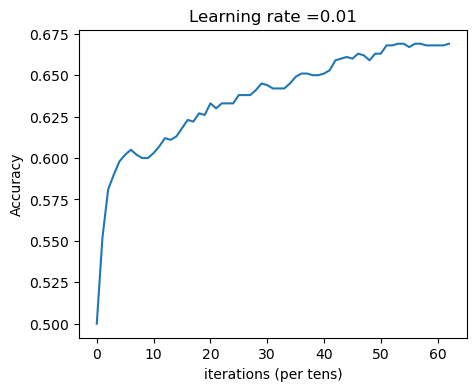

In [101]:
layers_dims = [3072, 10, 1]
parameters3 = Neural_Network(train_x, train_y, layers_dims, activation = "sigmoid",learning_rate = 0.01, num_iterations = 50000, print_acc = True, loss="logistic")

0.5030000000000002
0
Accuracy after iteration 0: 0.503000
0.6130000000000001
100
Accuracy after iteration 100: 0.613000
0.6390000000000001
200
Accuracy after iteration 200: 0.639000
0.6410000000000001
300
Accuracy after iteration 300: 0.641000
0.6530000000000001
400
Accuracy after iteration 400: 0.653000
0.6610000000000001
500
Accuracy after iteration 500: 0.661000
0.6630000000000001
600
Accuracy after iteration 600: 0.663000
0.6660000000000001
700
Accuracy after iteration 700: 0.666000
0.6670000000000001
800
Accuracy after iteration 800: 0.667000
Accuracy after iteration 900: 0.667000
0.6690000000000002
1000
Accuracy after iteration 1000: 0.669000
Accuracy after iteration 1100: 0.665000
Accuracy after iteration 1200: 0.664000
Accuracy after iteration 1300: 0.665000
Accuracy after iteration 1400: 0.665000
Accuracy after iteration 1500: 0.667000
Accuracy after iteration 1600: 0.669000
0.6700000000000002
1700
Accuracy after iteration 1700: 0.670000
Accuracy after iteration 1800: 0.667000

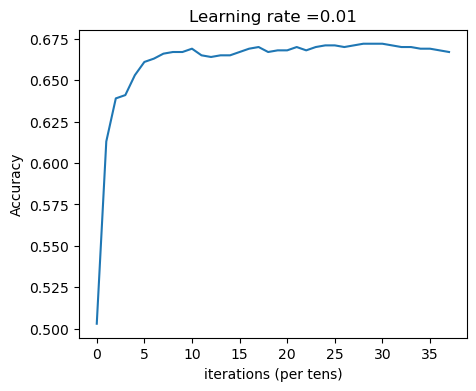

In [102]:
layers_dims = [3072, 1]
parameters4 = Neural_Network(train_x, train_y, layers_dims, activation = "sigmoid",learning_rate = 0.01, num_iterations = 10000, print_acc = True, loss="logistic")

0.4870000000000001
0
Accuracy after iteration 0: 0.487000
0.6160000000000001
100
Accuracy after iteration 100: 0.616000
0.6340000000000001
200
Accuracy after iteration 200: 0.634000
0.6460000000000001
300
Accuracy after iteration 300: 0.646000
Accuracy after iteration 400: 0.646000
0.6550000000000001
500
Accuracy after iteration 500: 0.655000
0.6630000000000001
600
Accuracy after iteration 600: 0.663000
0.6710000000000002
700
Accuracy after iteration 700: 0.671000
0.6750000000000002
800
Accuracy after iteration 800: 0.675000
0.6870000000000002
900
Accuracy after iteration 900: 0.687000
Accuracy after iteration 1000: 0.686000
0.6930000000000002
1100
Accuracy after iteration 1100: 0.693000
0.6940000000000002
1200
Accuracy after iteration 1200: 0.694000
0.6990000000000002
1300
Accuracy after iteration 1300: 0.699000
0.7010000000000002
1400
Accuracy after iteration 1400: 0.701000
Accuracy after iteration 1500: 0.700000
Accuracy after iteration 1600: 0.700000
Accuracy after iteration 1700: 

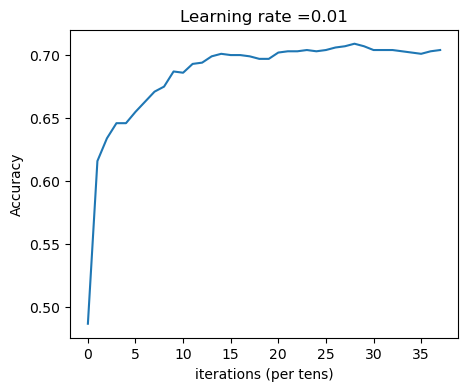

In [118]:
layers_dims = [3072, 100, 1]
parameters5 = Neural_Network(train_x, train_y, layers_dims, activation = "relu",learning_rate = 0.01, num_iterations = 50000, print_acc = True, loss="logistic")

In [117]:
forward(train_x,parameters5,"relu")[0]

array([[1., 1., 1., ..., 1., 1., 1.]])

0.4920000000000002
0
Accuracy after iteration 0: 0.492000
0.6020000000000001
100
Accuracy after iteration 100: 0.602000
0.6170000000000001
200
Accuracy after iteration 200: 0.617000
0.6280000000000001
300
Accuracy after iteration 300: 0.628000
0.6320000000000001
400
Accuracy after iteration 400: 0.632000
0.6390000000000001
500
Accuracy after iteration 500: 0.639000
0.6500000000000001
600
Accuracy after iteration 600: 0.650000
0.6540000000000001
700
Accuracy after iteration 700: 0.654000
Accuracy after iteration 800: 0.654000
0.6620000000000001
900
Accuracy after iteration 900: 0.662000
0.6690000000000002
1000
Accuracy after iteration 1000: 0.669000
0.6700000000000002
1100
Accuracy after iteration 1100: 0.670000
0.6720000000000002
1200
Accuracy after iteration 1200: 0.672000
0.6760000000000002
1300
Accuracy after iteration 1300: 0.676000
0.6770000000000002
1400
Accuracy after iteration 1400: 0.677000
0.6780000000000002
1500
Accuracy after iteration 1500: 0.678000
0.6830000000000002
1600

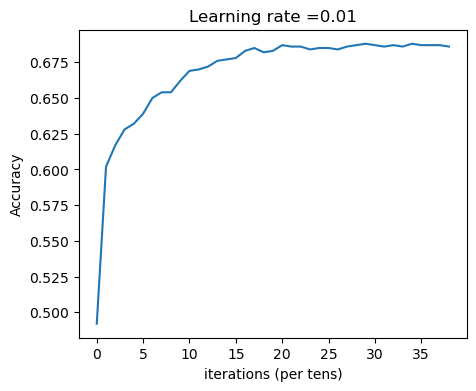

In [119]:
layers_dims = [3072, 100, 1]
parameters6 = Neural_Network(train_x, train_y, layers_dims, activation = "softplus",learning_rate = 0.01, num_iterations = 50000, print_acc = True, loss="logistic")

0.481
0
Accuracy after iteration 0: 0.481000
0.6110000000000001
100
Accuracy after iteration 100: 0.611000
0.6280000000000001
200
Accuracy after iteration 200: 0.628000
0.6460000000000001
300
Accuracy after iteration 300: 0.646000
0.6480000000000001
400
Accuracy after iteration 400: 0.648000
0.6510000000000001
500
Accuracy after iteration 500: 0.651000
0.6620000000000001
600
Accuracy after iteration 600: 0.662000
0.6680000000000001
700
Accuracy after iteration 700: 0.668000
0.6760000000000002
800
Accuracy after iteration 800: 0.676000
0.6790000000000002
900
Accuracy after iteration 900: 0.679000
0.6800000000000002
1000
Accuracy after iteration 1000: 0.680000
0.6830000000000002
1100
Accuracy after iteration 1100: 0.683000
0.6850000000000002
1200
Accuracy after iteration 1200: 0.685000
0.6860000000000002
1300
Accuracy after iteration 1300: 0.686000
Accuracy after iteration 1400: 0.685000
Accuracy after iteration 1500: 0.683000
Accuracy after iteration 1600: 0.683000
Accuracy after iterat

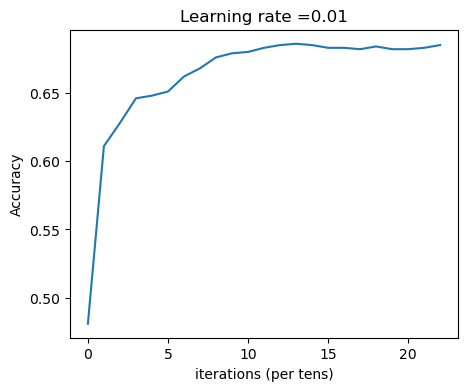

In [120]:
layers_dims = [3072, 100, 1]
parameters7 = Neural_Network(train_x, train_y, layers_dims, activation = "arctan",learning_rate = 0.01, num_iterations = 50000, print_acc = True, loss="logistic")

0.4980000000000002
0
Accuracy after iteration 0: 0.498000
0.6240000000000001
100
Accuracy after iteration 100: 0.624000
0.6410000000000001
200
Accuracy after iteration 200: 0.641000
0.6470000000000001
300
Accuracy after iteration 300: 0.647000
Accuracy after iteration 400: 0.618000
0.6490000000000001
500
Accuracy after iteration 500: 0.649000
0.6540000000000001
600
Accuracy after iteration 600: 0.654000
Accuracy after iteration 700: 0.649000
0.6550000000000001
800
Accuracy after iteration 800: 0.655000
0.6580000000000001
900
Accuracy after iteration 900: 0.658000
0.6590000000000001
1000
Accuracy after iteration 1000: 0.659000
0.6600000000000001
1100
Accuracy after iteration 1100: 0.660000
0.6640000000000001
1200
Accuracy after iteration 1200: 0.664000
0.6660000000000001
1300
Accuracy after iteration 1300: 0.666000
0.6750000000000002
1400
Accuracy after iteration 1400: 0.675000
0.6820000000000002
1500
Accuracy after iteration 1500: 0.682000
Accuracy after iteration 1600: 0.682000
0.6840

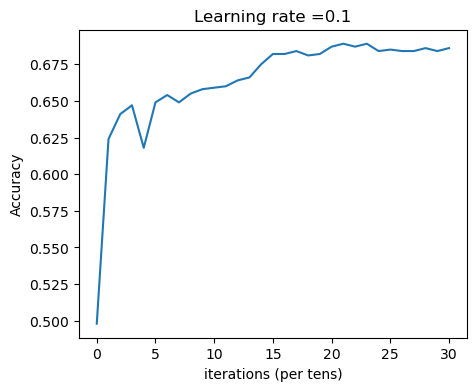

In [106]:
layers_dims = [3072, 100, 1]
parameters8 = Neural_Network(train_x, train_y, layers_dims, activation = "sigmoid",learning_rate = 0.1, num_iterations = 50000, print_acc = True, loss="logistic")

0.5000000000000002
0
Accuracy after iteration 0: 0.500000
Accuracy after iteration 100: 0.485000
0.5070000000000001
200
Accuracy after iteration 200: 0.507000
0.528
300
Accuracy after iteration 300: 0.528000
0.5650000000000001
400
Accuracy after iteration 400: 0.565000
0.5720000000000001
500
Accuracy after iteration 500: 0.572000
0.5740000000000001
600
Accuracy after iteration 600: 0.574000
0.5840000000000001
700
Accuracy after iteration 700: 0.584000
0.5900000000000001
800
Accuracy after iteration 800: 0.590000
Accuracy after iteration 900: 0.584000
Accuracy after iteration 1000: 0.583000
Accuracy after iteration 1100: 0.584000
Accuracy after iteration 1200: 0.588000
Accuracy after iteration 1300: 0.589000
Accuracy after iteration 1400: 0.587000
Accuracy after iteration 1500: 0.589000
Accuracy after iteration 1600: 0.588000
0.5930000000000001
1700
Accuracy after iteration 1700: 0.593000
Accuracy after iteration 1800: 0.591000
0.5940000000000001
1900
Accuracy after iteration 1900: 0.59

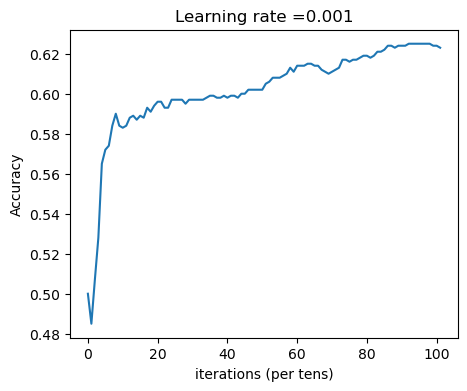

In [107]:
layers_dims = [3072, 100, 1]
parameters9 = Neural_Network(train_x, train_y, layers_dims, activation = "sigmoid",learning_rate = 0.001, num_iterations = 50000, print_acc = True, loss="logistic")

0.45000000000000007
0
Accuracy after iteration 0: 0.450000
0.6130000000000001
100
Accuracy after iteration 100: 0.613000
0.6310000000000001
200
Accuracy after iteration 200: 0.631000
0.6480000000000001
300
Accuracy after iteration 300: 0.648000
0.6590000000000001
400
Accuracy after iteration 400: 0.659000
0.6700000000000002
500
Accuracy after iteration 500: 0.670000
0.6850000000000002
600
Accuracy after iteration 600: 0.685000
0.6940000000000002
700
Accuracy after iteration 700: 0.694000
Accuracy after iteration 800: 0.686000
Accuracy after iteration 900: 0.687000
Accuracy after iteration 1000: 0.689000
Accuracy after iteration 1100: 0.689000
Accuracy after iteration 1200: 0.685000
Accuracy after iteration 1300: 0.685000
Accuracy after iteration 1400: 0.686000
Accuracy after iteration 1500: 0.684000
Accuracy after iteration 1600: 0.682000
Accuracy after iteration 1700: 0.687000
break


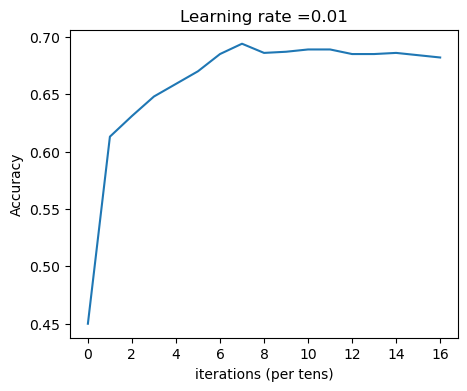

In [121]:
layers_dims = [3072, 768,384,128, 1]
parameters10 = Neural_Network(train_x, train_y, layers_dims, activation = "relu",learning_rate = 0.01, num_iterations = 10000, print_acc = True, loss="logistic")

In [191]:
layers_dims = [3072, 100, 1]
parameters11 = Neural_Network(train_x, train_y, layers_dims, activation = "relu",learning_rate = 0.001, num_iterations = 50000, print_acc = True, loss="logistic")

0.49200000000000016
0
Accuracy after iteration 0: 0.492000
0.5800000000000001
100
Accuracy after iteration 100: 0.580000
0.5940000000000001
200
Accuracy after iteration 200: 0.594000
0.6030000000000001
300
Accuracy after iteration 300: 0.603000
0.6060000000000001
400
Accuracy after iteration 400: 0.606000
0.6080000000000001
500
Accuracy after iteration 500: 0.608000
0.6120000000000001
600
Accuracy after iteration 600: 0.612000
Accuracy after iteration 700: 0.610000
Accuracy after iteration 800: 0.609000
Accuracy after iteration 900: 0.610000
0.6160000000000001
1000
Accuracy after iteration 1000: 0.616000
0.6190000000000001
1100
Accuracy after iteration 1100: 0.619000
0.6210000000000001
1200
Accuracy after iteration 1200: 0.621000
Accuracy after iteration 1300: 0.621000
Accuracy after iteration 1400: 0.621000
0.6250000000000001
1500
Accuracy after iteration 1500: 0.625000
0.6280000000000001
1600
Accuracy after iteration 1600: 0.628000
0.6300000000000001
1700
Accuracy after iteration 170

KeyboardInterrupt: 

0.5680000000000001
0
Accuracy after iteration 0: 0.568000
0.5870000000000002
100
Accuracy after iteration 100: 0.587000
0.6160000000000001
200
Accuracy after iteration 200: 0.616000
0.6750000000000002
300
Accuracy after iteration 300: 0.675000
0.6910000000000002
400
Accuracy after iteration 400: 0.691000
Accuracy after iteration 500: 0.691000
0.7030000000000002
600
Accuracy after iteration 600: 0.703000
Accuracy after iteration 700: 0.700000
Accuracy after iteration 800: 0.700000
Accuracy after iteration 900: 0.591000
Accuracy after iteration 1000: 0.690000
Accuracy after iteration 1100: 0.610000
Accuracy after iteration 1200: 0.695000
0.7070000000000002
1300
Accuracy after iteration 1300: 0.707000
0.7110000000000002
1400
Accuracy after iteration 1400: 0.711000
Accuracy after iteration 1500: 0.702000
Accuracy after iteration 1600: 0.585000
Accuracy after iteration 1700: 0.709000
0.7160000000000002
1800
Accuracy after iteration 1800: 0.716000
Accuracy after iteration 1900: 0.688000
Accu

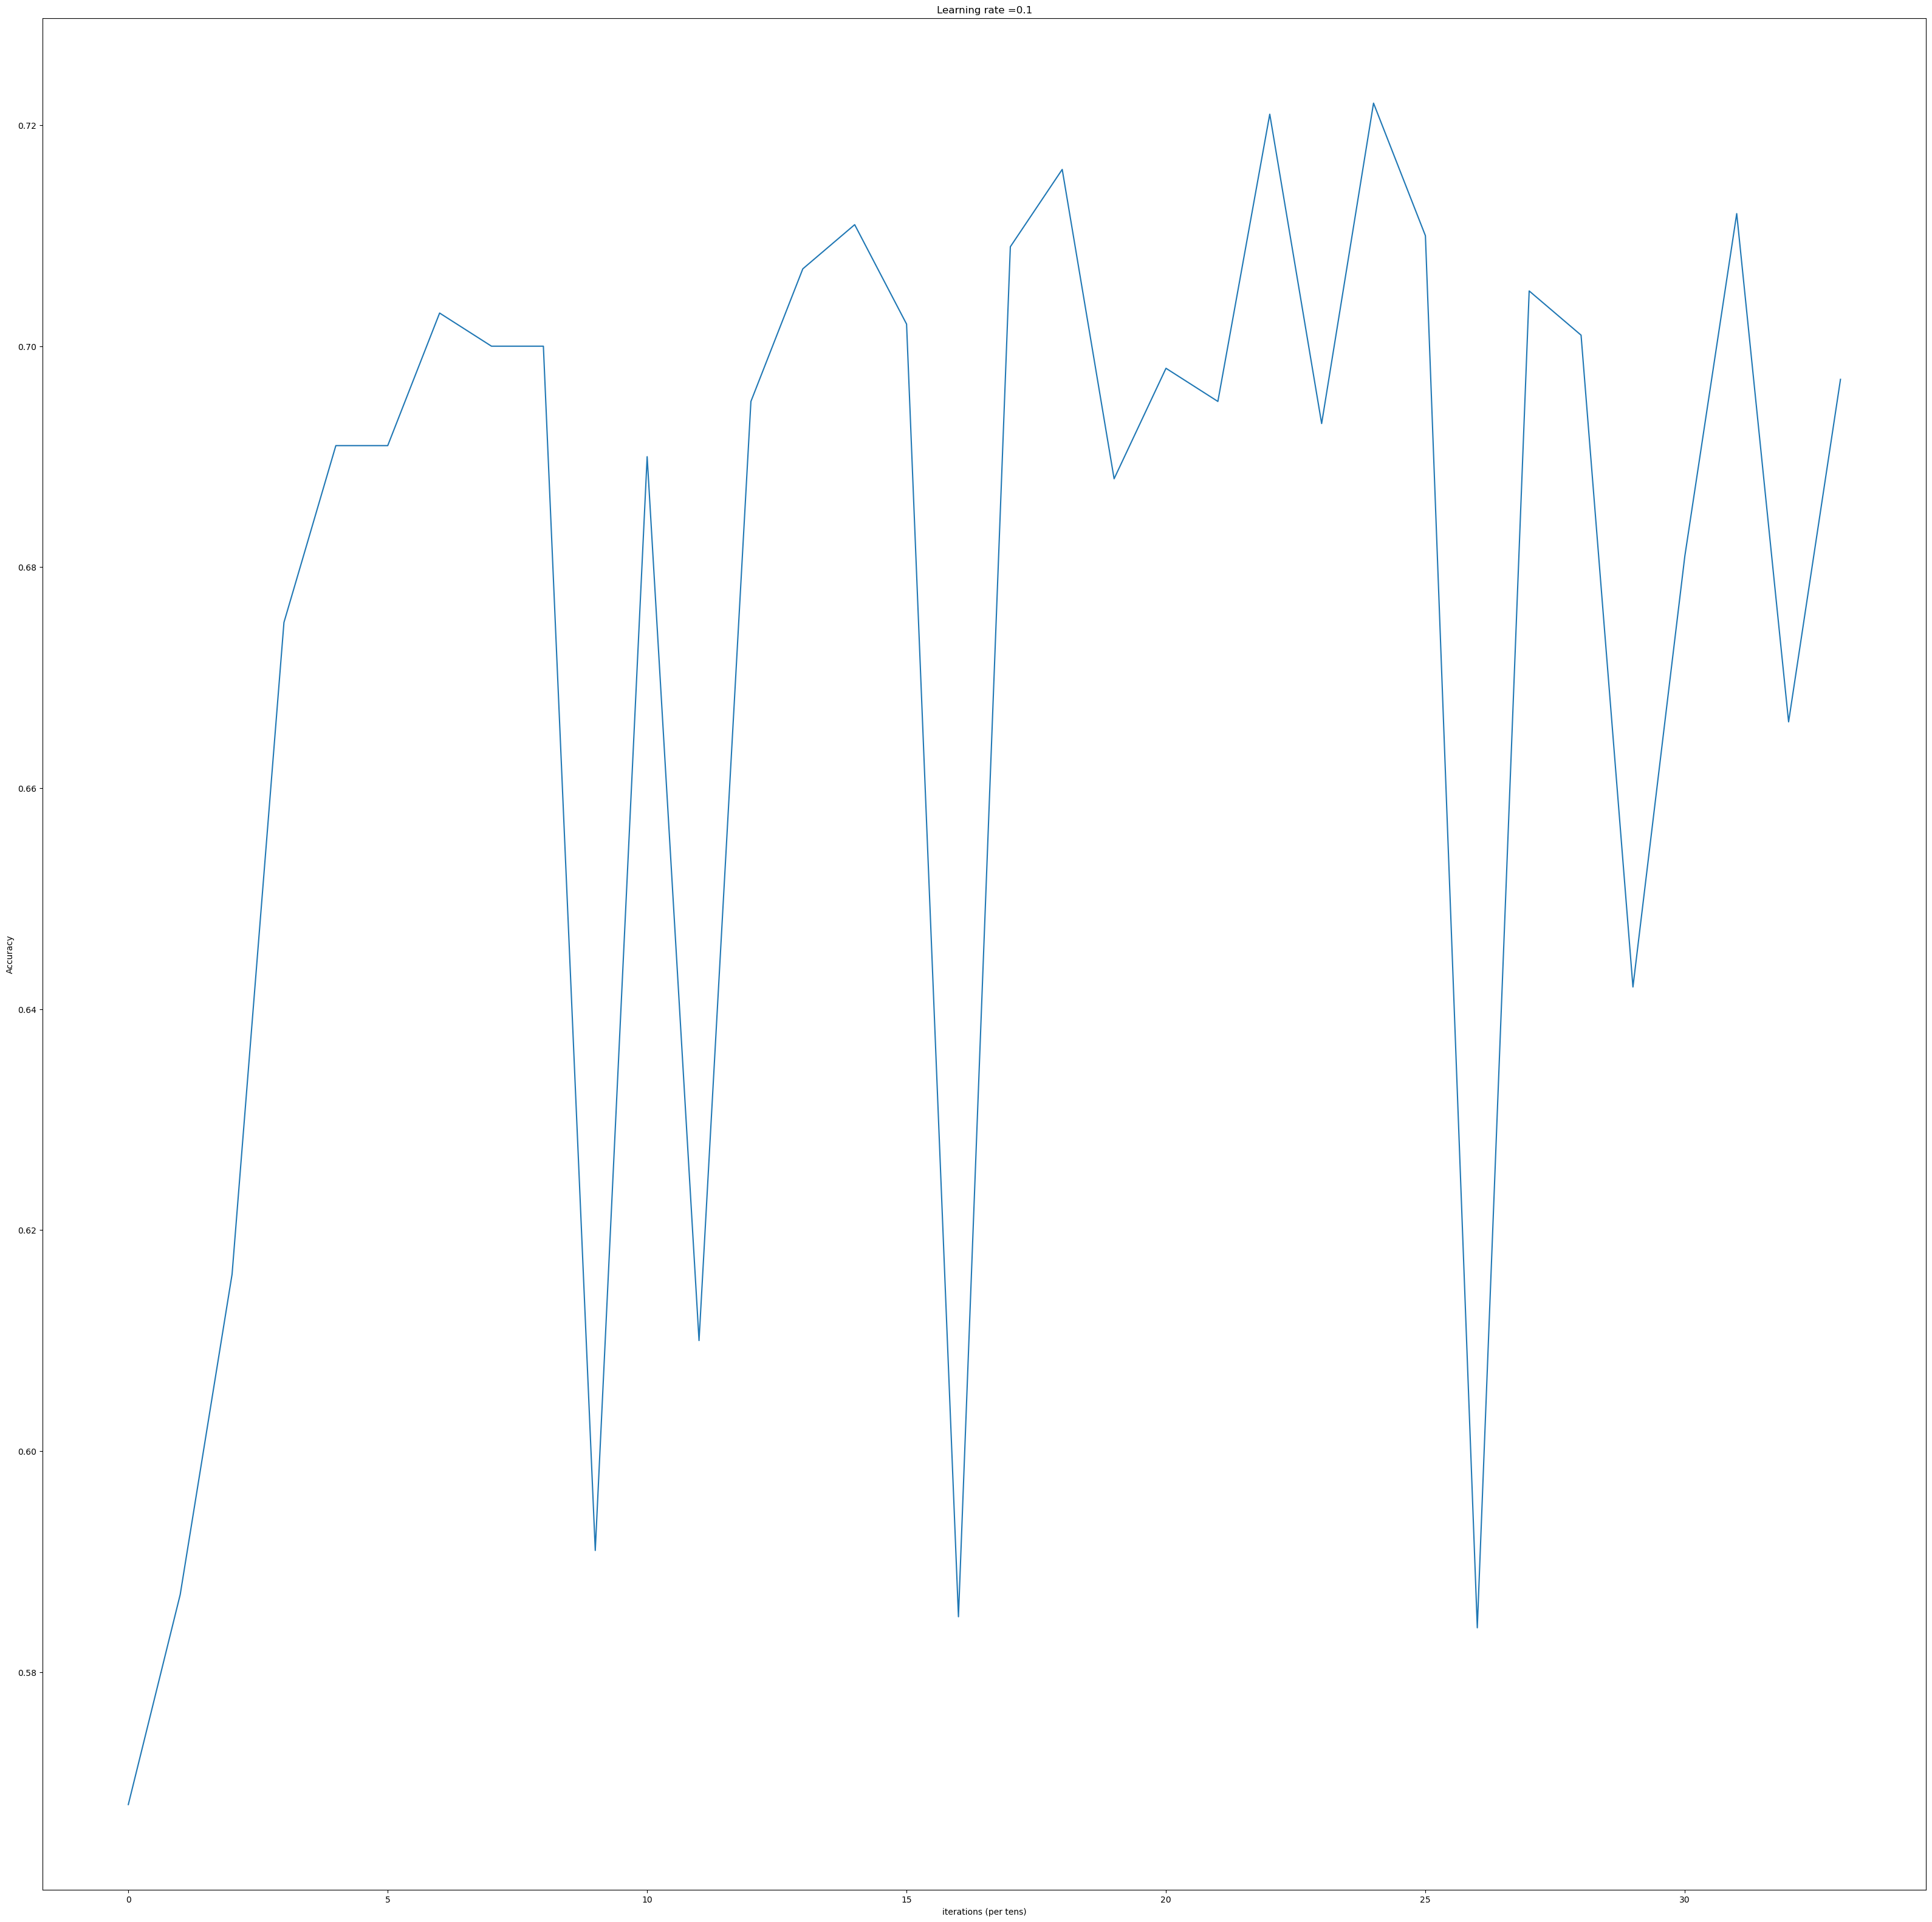

In [192]:
layers_dims = [3072, 100, 1]
parameters12 = Neural_Network(train_x, train_y, layers_dims, activation = "relu",learning_rate = 0.1, num_iterations = 50000, print_acc = True, loss="logistic")

0.5110000000000002
0
Accuracy after iteration 0: 0.511000
Accuracy after iteration 100: 0.500000


C:\Users\Samuel\AppData\Local\Temp\ipykernel_9124\4000974959.py:44: RuntimeWarning: overflow encountered in exp
  A = 1/(1+np.exp(-Z))
C:\Users\Samuel\AppData\Local\Temp\ipykernel_9124\4000974959.py:63: RuntimeWarning: overflow encountered in exp
  s = 1/(1+np.exp(-Z))


Accuracy after iteration 200: 0.500000
Accuracy after iteration 300: 0.500000
Accuracy after iteration 400: 0.500000
Accuracy after iteration 500: 0.500000
Accuracy after iteration 600: 0.500000
Accuracy after iteration 700: 0.500000
Accuracy after iteration 800: 0.500000
Accuracy after iteration 900: 0.500000
Accuracy after iteration 1000: 0.500000
break


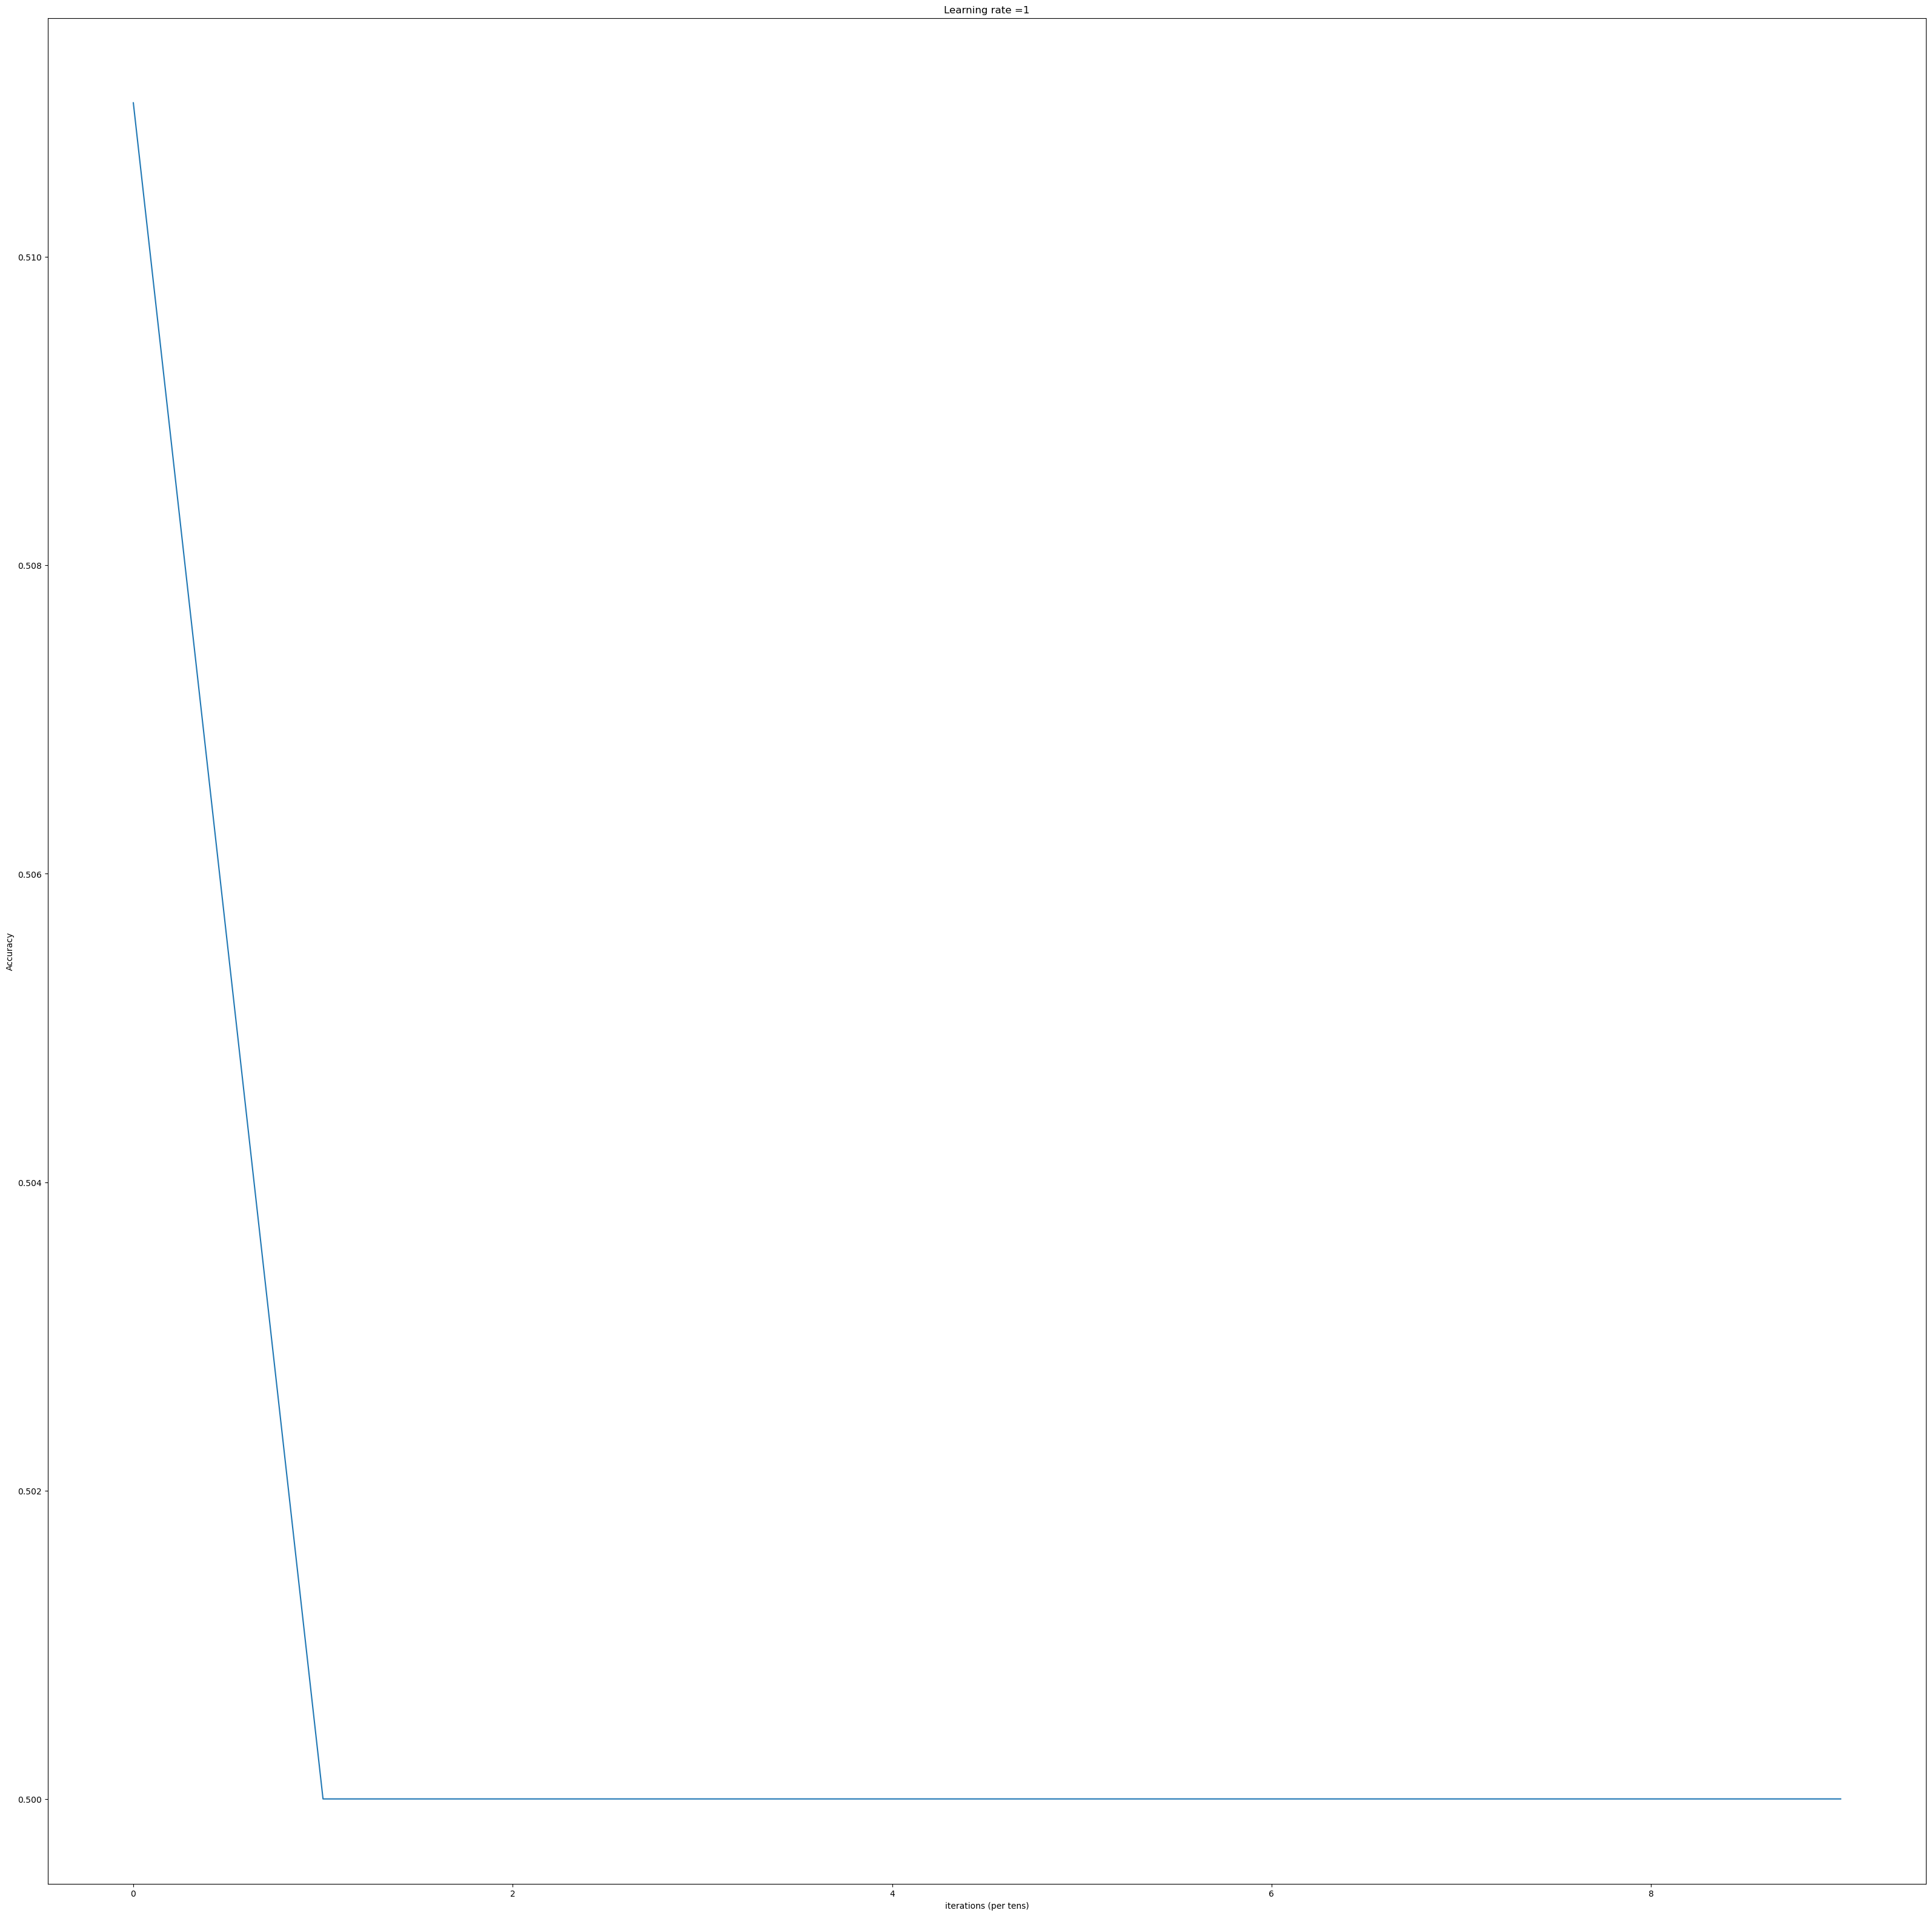

In [193]:
layers_dims = [3072, 100, 1]
parameters12 = Neural_Network(train_x, train_y, layers_dims, activation = "relu",learning_rate = 1, num_iterations = 50000, print_acc = True, loss="logistic")

In [154]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    
    for i in range(10):
        index = mislabeled_indices[1][i]
        plt.subplot(2, 10, i + 1)
        plt.imshow(X[:,index].reshape(32,32,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])] + " \n Class: " + classes[y[0,index]])



0.7195000000000003
[[1. 0. 1. 0. 1. 0. 1. 0. 1. 1.]]


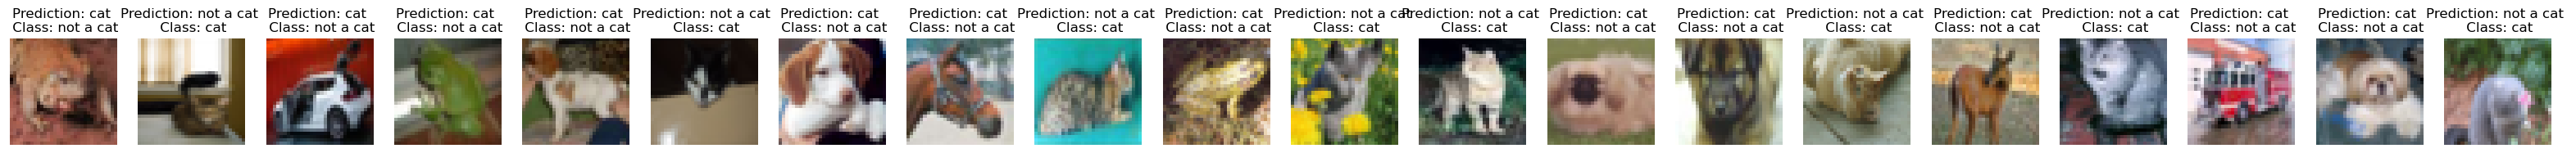

In [190]:
classes=["not a cat","cat"]
pred_test=forward(test_x,parameters5,"relu")[0]
p = np.zeros((1,pred_test.shape[1]))

for i in range(0, pred_test.shape[1]):
        if pred_test[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0


print(np.sum((p == test_y)/pred_test.shape[1]))

print(p[:,0:10])

print_mislabeled_images(classes, test_x, test_y, p)

In [73]:
print(train_x.shape)
test=np.sum(2*train_x[:,0:3]-(train_x[:,0:3]+1))
print(test)

(3072, 50000)
-4788.282352941176


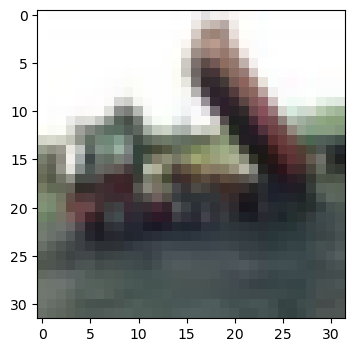

In [66]:
plt.imshow(X_train[2])